# Корнилов А.И.
#  18-АС
#  6 Вариант

**Устанавливаем keras tuner.**

In [ ]:
!pip install -U keras-tuner

     |████████████████████████████████| 61kB 2.0MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.1-cp36-none-any.whl size=73200 sha256=bf1a6c779ef993b89b7777620356f5758434b6c650df4ba29ae649bbc5eccc45
  Stored in directory: /root/.cache/pip/wheels/b9/cc/62/52716b70dd90f3db12519233c3a93a5360bc672da1a10ded43
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp36-none-any.whl size=15356 sha256=ad87e0ab25cd6b1c5459cbd4a4485747c43980332179d376db404c1c00da99f4
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


**Импортируем модули.**

In [ ]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import Callback
from kerastuner.tuners import Hyperband
import IPython
import numpy as np
from google.colab import files
import pandas as pd
import matplotlib.pyplot as plt

**Загружаем данные**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train = pd.read_csv("/content/drive/My Drive/train.csv")

**Просмотр данных**

In [ ]:
train.head()

,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,cat11,cat12,cat13,cat14,cat15,cat16,cat17,cat18,cat19,cat20,cat21,cat22,cat23,cat24,cat25,cat26,cat27,cat28,cat29,cat30,cat31,cat32,cat33,cat34,cat35,cat36,cat37,cat38,cat39,...,cat92,cat93,cat94,cat95,cat96,cat97,cat98,cat99,cat100,cat101,cat102,cat103,cat104,cat105,cat106,cat107,cat108,cat109,cat110,cat111,cat112,cat113,cat114,cat115,cat116,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
0,1,A,B,A,B,A,A,A,A,B,A,B,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,...,A,D,B,C,E,A,C,T,B,G,A,A,I,E,G,J,G,BU,BC,C,AS,S,A,O,LB,0.726300,0.245921,0.187583,0.789639,0.310061,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843,2213.18
1,2,A,B,A,A,A,A,A,A,B,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,...,A,D,D,C,E,E,D,T,L,F,A,A,E,E,I,K,K,BI,CQ,A,AV,BM,A,O,DP,0.330514,0.737068,0.592681,0.614134,0.885834,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496,1283.60
2,5,A,B,A,A,B,A,A,A,B,B,B,B,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,...,A,D,D,C,E,E,A,D,L,O,A,B,E,F,H,F,A,AB,DK,A,C,AF,A,I,GK,0.261841,0.358319,0.484196,0.236924,0.397069,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425,3005.09
3,10,B,B,A,B,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,...,A,D,D,C,E,E,D,T,I,D,A,A,E,E,I,K,K,BI,CS,C,N,AE,A,O,DJ,0.321594,0.555782,0.527991,0.373816,0.422268,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642,939.85
4,11,A,B,A,B,A,A,A,A,B,B,A,B,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,...,H,D,B,D,E,E,A,P,F,J,A,A,D,E,K,G,B,H,C,C,Y,BM,A,K,CK,0.273204,0.159990,0.527991,0.473202,0.704268,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606,2763.85


**Стандартизация данных**


In [ ]:
labelencoder = LabelEncoder()
cat = pd.DataFrame()
for i in range(1,117):
  cat[f'cat{i}'] = labelencoder.fit_transform(train[f'cat{i}'])
  cat_norm = (cat - cat.mean()) / (cat.max() - cat.min())
data_cont = train.get([f'cont{i}' for i in range(1, 15)])
data_loss = train.get('loss')

In [ ]:
cat_norm.head()

,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,cat11,cat12,cat13,cat14,cat15,cat16,cat17,cat18,cat19,cat20,cat21,cat22,cat23,cat24,cat25,cat26,cat27,cat28,cat29,cat30,cat31,cat32,cat33,cat34,cat35,cat36,cat37,cat38,cat39,cat40,...,cat77,cat78,cat79,cat80,cat81,cat82,cat83,cat84,cat85,cat86,cat87,cat88,cat89,cat90,cat91,cat92,cat93,cat94,cat95,cat96,cat97,cat98,cat99,cat100,cat101,cat102,cat103,cat104,cat105,cat106,cat107,cat108,cat109,cat110,cat111,cat112,cat113,cat114,cat115,cat116
0,-0.248346,0.566706,-0.054827,0.681799,-0.342936,-0.300688,-0.024289,-0.058645,0.600697,-0.149242,0.893096,-0.151303,-0.103373,-0.012091,-0.000181,-0.034383,-0.006951,-0.005241,-0.009601,-0.001083,-0.002193,-0.000228,0.836059,-0.033672,-0.097436,-0.059469,-0.106564,-0.039189,-0.01978,-0.018894,-0.028346,-0.006431,-0.005082,-0.003101,-0.001131,-0.169952,-0.119951,-0.100867,-0.026153,-0.043538,...,0.00225,-0.001018,-0.084818,0.175089,0.105568,-0.037070,0.648088,0.098828,-0.002214,0.394299,-0.055702,-0.068784,-0.003714,-0.009945,-0.167622,-0.279182,0.051272,-0.228796,-0.141752,0.008551,-0.406192,0.1865,0.169033,-0.461127,0.191385,-0.012249,-0.053781,0.151946,-0.040892,-0.04072,0.106171,0.148643,0.170943,-0.351717,0.058973,-0.098466,0.395911,-0.08066,0.099741,0.359131
1,-0.248346,0.566706,-0.054827,-0.318201,-0.342936,-0.300688,-0.024289,-0.058645,0.600697,0.850758,-0.106904,-0.151303,-0.103373,-0.012091,-0.000181,-0.034383,-0.006951,-0.005241,-0.009601,-0.001083,-0.002193,-0.000228,-0.163941,-0.033672,-0.097436,-0.059469,-0.106564,-0.039189,-0.01978,-0.018894,-0.028346,-0.006431,-0.005082,-0.003101,-0.001131,-0.169952,-0.119951,-0.100867,-0.026153,-0.043538,...,0.00225,-0.001018,-0.084818,0.175089,0.105568,-0.370404,-0.018579,0.098828,-0.002214,0.394299,-0.055702,-0.068784,-0.003714,-0.009945,-0.167622,-0.279182,0.051272,0.104538,-0.141752,0.008551,0.260474,0.4365,0.169033,0.253159,0.135829,-0.012249,-0.053781,-0.098054,-0.040892,0.08428,0.158803,0.548643,0.026365,-0.067102,-0.074360,-0.038466,0.112578,-0.08066,0.099741,-0.207023
2,-0.248346,0.566706,-0.054827,-0.318201,0.657064,-0.300688,-0.024289,-0.058645,0.600697,0.850758,0.893096,0.848697,0.896627,-0.012091,-0.000181,-0.034383,-0.006951,-0.005241,-0.009601,-0.001083,-0.002193,-0.000228,-0.163941,-0.033672,-0.097436,-0.059469,-0.106564,-0.039189,-0.01978,-0.018894,-0.028346,-0.006431,-0.005082,-0.003101,-0.001131,0.830048,-0.119951,-0.100867,-0.026153,-0.043538,...,0.00225,-0.001018,-0.084818,-0.491578,0.105568,-0.037070,0.648088,0.098828,-0.002214,-0.272367,-0.055702,-0.068784,-0.003714,-0.009945,-0.167622,-0.279182,0.051272,0.104538,-0.141752,0.008551,0.260474,-0.3135,-0.764301,0.253159,0.635829,-0.012249,0.029552,-0.098054,0.011739,0.02178,-0.104355,-0.451357,-0.347129,0.086744,-0.074360,0.081534,-0.437422,-0.08066,-0.172986,0.002208
3,0.751654,0.566706,-0.054827,0.681799,-0.342936,-0.300688,-0.024289,-0.058645,0.600697,-0.149242,-0.106904,-0.151303,-0.103373,-0.012091,-0.000181,-0.034383,-0.006951,-0.005241,-0.009601,-0.001083,-0.002193,-0.000228,0.836059,-0.033672,-0.097436,-0.059469,-0.106564,-0.039189,-0.01978,-0.018894,-0.028346,-0.006431,-0.005082,-0.003101,-0.001131,-0.169952,-0.119951,-0.100867,-0.026153,-0.043538,...,0.00225,-0.001018,-0.084818,0.175089,0.105568,0.629596,-0.018579,0.098828,-0.002214,0.394299,-0.055702,-0.068784,-0.003714,-0.009945,-0.167622,-0.279182,0.051272,0.104538,-0.141752,0.008551,0.260474,0.4365,0.169033,0.038873,0.024718,-0.012249,-0.053781,-0.098054,-0.040892,0.08428,0.158803,0.548643,0.026365,-0.051717,0.058973,0.301534,-0.454089,-0.08066,0.099741,-0.225484
4,-0.248346,0.566706,-0.054827,0.681799,-0.342936,-0.300688,-0.024289,-0.058645,0.600697,0.850758,-0.106904,0.848697,-0.103373,-0.012091,-0.000181,-0.034383,-0.006951,-0.005241,-0.009601,-0.001083,-0.002193,-0.000228,0.836059,-0.033672,-0.097436,-0.059469,-0.106564,-0.039189,-0.01978,-0.018894,-0.028346,-0.006431,-0.005082,-0.003101,-0.001131,-0.169952,-0.119951,-0.100867,-0.026153,-0.043538,...,0.00

**Соединяем данные обратно**

In [ ]:
data = pd.concat([cat_norm, data_cont, data_loss], axis=1)

In [ ]:
data.head()

,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,cat11,cat12,cat13,cat14,cat15,cat16,cat17,cat18,cat19,cat20,cat21,cat22,cat23,cat24,cat25,cat26,cat27,cat28,cat29,cat30,cat31,cat32,cat33,cat34,cat35,cat36,cat37,cat38,cat39,cat40,...,cat92,cat93,cat94,cat95,cat96,cat97,cat98,cat99,cat100,cat101,cat102,cat103,cat104,cat105,cat106,cat107,cat108,cat109,cat110,cat111,cat112,cat113,cat114,cat115,cat116,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
0,-0.248346,0.566706,-0.054827,0.681799,-0.342936,-0.300688,-0.024289,-0.058645,0.600697,-0.149242,0.893096,-0.151303,-0.103373,-0.012091,-0.000181,-0.034383,-0.006951,-0.005241,-0.009601,-0.001083,-0.002193,-0.000228,0.836059,-0.033672,-0.097436,-0.059469,-0.106564,-0.039189,-0.01978,-0.018894,-0.028346,-0.006431,-0.005082,-0.003101,-0.001131,-0.169952,-0.119951,-0.100867,-0.026153,-0.043538,...,-0.279182,0.051272,-0.228796,-0.141752,0.008551,-0.406192,0.1865,0.169033,-0.461127,0.191385,-0.012249,-0.053781,0.151946,-0.040892,-0.04072,0.106171,0.148643,0.170943,-0.351717,0.058973,-0.098466,0.395911,-0.08066,0.099741,0.359131,0.726300,0.245921,0.187583,0.789639,0.310061,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843,2213.18
1,-0.248346,0.566706,-0.054827,-0.318201,-0.342936,-0.300688,-0.024289,-0.058645,0.600697,0.850758,-0.106904,-0.151303,-0.103373,-0.012091,-0.000181,-0.034383,-0.006951,-0.005241,-0.009601,-0.001083,-0.002193,-0.000228,-0.163941,-0.033672,-0.097436,-0.059469,-0.106564,-0.039189,-0.01978,-0.018894,-0.028346,-0.006431,-0.005082,-0.003101,-0.001131,-0.169952,-0.119951,-0.100867,-0.026153,-0.043538,...,-0.279182,0.051272,0.104538,-0.141752,0.008551,0.260474,0.4365,0.169033,0.253159,0.135829,-0.012249,-0.053781,-0.098054,-0.040892,0.08428,0.158803,0.548643,0.026365,-0.067102,-0.074360,-0.038466,0.112578,-0.08066,0.099741,-0.207023,0.330514,0.737068,0.592681,0.614134,0.885834,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496,1283.60
2,-0.248346,0.566706,-0.054827,-0.318201,0.657064,-0.300688,-0.024289,-0.058645,0.600697,0.850758,0.893096,0.848697,0.896627,-0.012091,-0.000181,-0.034383,-0.006951,-0.005241,-0.009601,-0.001083,-0.002193,-0.000228,-0.163941,-0.033672,-0.097436,-0.059469,-0.106564,-0.039189,-0.01978,-0.018894,-0.028346,-0.006431,-0.005082,-0.003101,-0.001131,0.830048,-0.119951,-0.100867,-0.026153,-0.043538,...,-0.279182,0.051272,0.104538,-0.141752,0.008551,0.260474,-0.3135,-0.764301,0.253159,0.635829,-0.012249,0.029552,-0.098054,0.011739,0.02178,-0.104355,-0.451357,-0.347129,0.086744,-0.074360,0.081534,-0.437422,-0.08066,-0.172986,0.002208,0.261841,0.358319,0.484196,0.236924,0.397069,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425,3005.09
3,0.751654,0.566706,-0.054827,0.681799,-0.342936,-0.300688,-0.024289,-0.058645,0.600697,-0.149242,-0.106904,-0.151303,-0.103373,-0.012091,-0.000181,-0.034383,-0.006951,-0.005241,-0.009601,-0.001083,-0.002193,-0.000228,0.836059,-0.033672,-0.097436,-0.059469,-0.106564,-0.039189,-0.01978,-0.018894,-0.028346,-0.006431,-0.005082,-0.003101,-0.001131,-0.169952,-0.119951,-0.100867,-0.026153,-0.043538,...,-0.279182,0.051272,0.104538,-0.141752,0.008551,0.260474,0.4365,0.169033,0.038873,0.024718,-0.012249,-0.053781,-0.098054,-0.040892,0.08428,0.158803,0.548643,0.026365,-0.051717,0.058973,0.301534,-0.454089,-0.08066,0.099741,-0.225484,0.321594,0.555782,0.527991,0.373816,0.422268,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642,939.85
4,-0.248346,0.566706,-0.054827,0.681799,-0.342936,-0.300688,-0.024289,-0.058645,0.600697,0.850758,-0.106904,0.848697,-0.103373,-0.012091,-0.000181,-0.034383,-0.006951,-0.005241,-0.009601,-0.001083,-0.002193,-0.000228,0.836059,-0.033672,-0.097436,-0.059469,-0.106564,-0.039189,-0.01978,-0.018894,-0.028346,-0.006431,-0.005082,-0.003101,-0.001131,-0.169952,-0.119951,-0.100867,-0.026153,-0.043538,...,0.554151,0.051272,-0.228796,0.108248,0.008551,0.2604

**Разделение данных на test и train**

In [ ]:
split = 0.7
random_seed = 200

train.drop(['id'], axis=1, inplace=True)
y_data = data_loss
x_data = data.drop(['loss'], axis=1)

x_train = x_data.sample(frac=split, random_state=random_seed)
x_test = x_data.drop(x_train.index)

y_train = y_data.sample(frac=split, random_state=random_seed)
y_test = y_data.drop(y_train.index)

In [ ]:
x_train.head()

,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,cat11,cat12,cat13,cat14,cat15,cat16,cat17,cat18,cat19,cat20,cat21,cat22,cat23,cat24,cat25,cat26,cat27,cat28,cat29,cat30,cat31,cat32,cat33,cat34,cat35,cat36,cat37,cat38,cat39,cat40,...,cat91,cat92,cat93,cat94,cat95,cat96,cat97,cat98,cat99,cat100,cat101,cat102,cat103,cat104,cat105,cat106,cat107,cat108,cat109,cat110,cat111,cat112,cat113,cat114,cat115,cat116,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14
35320,-0.248346,0.566706,0.945173,-0.318201,-0.342936,-0.300688,-0.024289,-0.058645,0.600697,0.850758,0.893096,0.848697,0.896627,-0.012091,-0.000181,0.965617,-0.006951,-0.005241,-0.009601,-0.001083,-0.002193,-0.000228,-0.163941,-0.033672,-0.097436,-0.059469,-0.106564,-0.039189,-0.01978,-0.018894,-0.028346,-0.006431,-0.005082,-0.003101,-0.001131,-0.169952,-0.119951,-0.100867,-0.026153,-0.043538,...,-0.167622,-0.279182,0.051272,-0.228796,-0.141752,0.008551,-0.406192,0.1865,0.169033,0.253159,0.691385,-0.012249,-0.053781,0.214446,0.011739,-0.04072,-0.051724,0.148643,0.026365,0.248283,-0.074360,-0.398466,0.295911,-0.08066,0.054287,0.371439,0.893232,0.159990,0.280933,0.713852,0.281143,0.665834,0.377559,0.75964,0.93383,0.78770,0.711942,0.714544,0.751507,0.793129
11967,0.751654,0.566706,-0.054827,0.681799,-0.342936,-0.300688,-0.024289,-0.058645,0.600697,0.850758,0.893096,0.848697,-0.103373,-0.012091,-0.000181,-0.034383,-0.006951,-0.005241,-0.009601,-0.001083,-0.002193,-0.000228,0.836059,-0.033672,-0.097436,-0.059469,-0.106564,-0.039189,-0.01978,-0.018894,-0.028346,-0.006431,-0.005082,-0.003101,-0.001131,-0.169952,-0.119951,-0.100867,-0.026153,-0.043538,...,0.118092,-0.279182,0.051272,0.104538,0.108248,0.008551,-0.072859,-0.3135,-0.030967,0.110302,0.524718,-0.012249,-0.053781,-0.098054,0.011739,-0.04072,-0.051724,-0.151357,0.026365,0.286744,0.058973,0.121534,0.229244,-0.08066,-0.082077,-0.003946,0.296829,0.199504,0.634224,0.215482,0.281143,0.367466,0.562623,0.30768,0.40252,0.28677,0.392500,0.384201,0.276878,0.818243
16312,-0.248346,0.566706,-0.054827,-0.318201,0.657064,-0.300688,-0.024289,-0.058645,0.600697,-0.149242,-0.106904,-0.151303,-0.103373,-0.012091,-0.000181,-0.034383,-0.006951,-0.005241,-0.009601,-0.001083,-0.002193,-0.000228,-0.163941,-0.033672,-0.097436,-0.059469,-0.106564,-0.039189,-0.01978,-0.018894,-0.028346,-0.006431,-0.005082,-0.003101,-0.001131,-0.169952,-0.119951,0.899133,-0.026153,-0.043538,...,-0.024765,-0.279182,-0.198728,-0.228796,0.358248,0.008551,0.593808,0.6865,0.035699,0.038873,-0.030837,-0.012249,0.029552,0.089446,-0.040892,-0.04072,0.053540,0.048643,0.026365,0.179052,-0.074360,0.221534,0.395911,-0.08066,0.008832,0.119131,0.637419,0.422197,0.280933,0.761209,0.696981,0.646468,0.411042,0.52450,0.64873,0.79139,0.492200,0.500382,0.689974,0.387539
97332,-0.248346,-0.433294,-0.054827,0.681799,0.657064,-0.300688,-0.024289,-0.058645,-0.399303,-0.149242,-0.106904,-0.151303,-0.103373,-0.012091,-0.000181,-0.034383,-0.006951,-0.005241,-0.009601,-0.001083,-0.002193,-0.000228,0.836059,-0.033672,0.902564,0.940531,0.893436,-0.039189,-0.01978,-0.018894,-0.028346,-0.006431,-0.005082,-0.003101,-0.001131,-0.169952,-0.119951,-0.100867,-0.026153,0.956462,...,-0.167622,-0.279182,0.051272,0.104538,0.108248,0.008551,-0.072859,-0.3135,-0.030967,0.467445,-0.141948,-0.012249,0.279552,0.026946,0.169634,-0.04072,-0.104355,-0.151357,0.026365,-0.228640,0.392306,-0.158466,-0.420756,-0.08066,-0.082077,0.112977,0.444104,0.737068,0.865911,0.222469,0.281143,0.471277,0.684165,0.36636,0.50420,0.34928,0.853569,0.852865,0.318646,0.356840
41478,-0.248346,0.566706,0.945173,-0.318201,-0.342936,-0.300688,0.975711,0.941355,-0.399303,-0.149242,-0.106904,-0.151303,-0.103373,0.987909,-0.000181,-0.034383,0.993049,-0.005241,0.990399,-0.001083,-0.002193,-0.000228,-0.163941,-0.033672,-0.097436,-0.059469,-0.106564,-0.039189,-0.01978,-0.018894,-0.028346,-0.006431,-0.005082,-0.003101,-0.001131,-0.169952,-0.119951,-0.100867,-0.026153,-0.043538,...,-0.024765,0.554151,0.051272,0

**Описание модели**

In [ ]:
def build_model(hp):
  activation_choice = hp.Choice('activation', values=['relu', 'sigmoid', 'tanh', 'elu', 'selu'])
  hidden_layers_choice = hp.Choice('hidden_layers', values=[0, 1, 2])

  model = Sequential()
  model.add(
      Dense(
          units=hp.Int(
              'input_units',
              min_value=128, 
              max_value=256, 
              step=16,
          ), 
          input_dim=x_train.shape[1], 
          activation=activation_choice,
      ),
  )
  model.add(Dropout(0.3))
  for i in range(hidden_layers_choice):
    model.add(
        Dense(
            units=hp.Int(
                f'layer_{i + 1}_units',
                min_value=64 // (i + 1),
                max_value=128 // (i + 1),
                step=8 // (i + 1),
            ),
            activation=activation_choice
        )
    )
  model.add(Dense(1))

  model.compile(
      optimizer='adam', 
      loss='mae',
      metrics=['mae'], 
  )

  return model

**Создание тюнера**

In [ ]:
tuner = Hyperband(
    build_model,
    objective='mae',
    factor = 3, 
    hyperband_iterations = 2,
    max_epochs=10,
    directory='models',
    project_name='lab1',
)

In [ ]:
tuner.search_space_summary()

**Очистка результатов в конце каждого шага обучения и поиск оптимальных гиперпараметров**

In [ ]:
class ClearTrainingOutput(Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)


In [ ]:
tuner.search(
    x_train,
    y_train,
    validation_split=0.2,
    verbose=2,
    callbacks = [ClearTrainingOutput()],
)

INFO:tensorflow:Oracle triggered exit


**Создание модели**

In [ ]:
best_hps = tuner.get_best_hyperparameters()[0]
model = tuner.hypermodel.build(best_hps)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 208)               27248     
_________________________________________________________________
dropout (Dropout)            (None, 208)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 112)               23408     
_________________________________________________________________
dense_2 (Dense)              (None, 44)                4972      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 45        
Total params: 55,673
Trainable params: 55,673
Non-trainable params: 0
_________________________________________________________________


**Обучаем модель**

In [ ]:
history = model.fit(x_train, y_train, epochs=25, batch_size=30, validation_split=0.2, verbose=2)

Epoch 1/25
3516/3516 - 5s - loss: 1341.1865 - mae: 1341.1865 - val_loss: 1279.5129 - val_mae: 1279.5129
Epoch 2/25
3516/3516 - 5s - loss: 1264.2582 - mae: 1264.2582 - val_loss: 1247.2667 - val_mae: 1247.2670
Epoch 3/25
3516/3516 - 5s - loss: 1235.9043 - mae: 1235.9043 - val_loss: 1226.9608 - val_mae: 1226.9608
Epoch 4/25
3516/3516 - 5s - loss: 1220.4290 - mae: 1220.4290 - val_loss: 1215.6100 - val_mae: 1215.6100
Epoch 5/25
3516/3516 - 5s - loss: 1212.1815 - mae: 1212.1815 - val_loss: 1211.5972 - val_mae: 1211.5972
Epoch 6/25
3516/3516 - 5s - loss: 1206.8115 - mae: 1206.8115 - val_loss: 1208.2439 - val_mae: 1208.2439
Epoch 7/25
3516/3516 - 5s - loss: 1202.3840 - mae: 1202.3840 - val_loss: 1202.9548 - val_mae: 1202.9548
Epoch 8/25
3516/3516 - 5s - loss: 1199.3203 - mae: 1199.3203 - val_loss: 1205.8092 - val_mae: 1205.8092
Epoch 9/25
3516/3516 - 5s - loss: 1196.0966 - mae: 1196.0966 - val_loss: 1198.5536 - val_mae: 1198.5536
Epoch 10/25
3516/3516 - 5s - loss: 1194.3372 - mae: 1194.3372 - 

**Сохраняем модель**

In [ ]:
model.save(f'/content/drive/My Drive/lab1.h5')

**Строим график потерь**

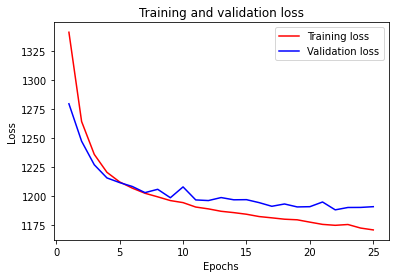

<Figure size 432x288 with 0 Axes>

In [ ]:
def graphs(history):
  history = history.history
  loss = history["loss"]
  val_loss = history["val_loss"]
  epochs = range(1, len(history['loss']) + 1)
  plt.plot(epochs, loss, 'r', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()
  plt.clf()

graphs(history)

In [ ]:
mae = model.evaluate(x_test, y_test, verbose=0)[1]
print(f'Средняя абсолютная ошибка = {mae}')

Средняя абсолютная ошибка = 1181.644287109375


**Выполняем предсказание для тестовой выборки**

In [ ]:
pred = model.predict(x_test)

**Печатаем примеры результатов**

In [ ]:
y_test_normal=y_test.reset_index(drop=True)

In [ ]:
for i in range(0,4):
  print("Предсказанная выплата:", pred[i])
  print("Реальная выплата:", y_test_normal[i])
  print("")

Предсказанная выплата: [1636.6881]
Реальная выплата: 2213.18

Предсказанная выплата: [4732.258]
Реальная выплата: 3005.09

Предсказанная выплата: [3674.7288]
Реальная выплата: 2763.85

Предсказанная выплата: [1341.699]
Реальная выплата: 1132.22



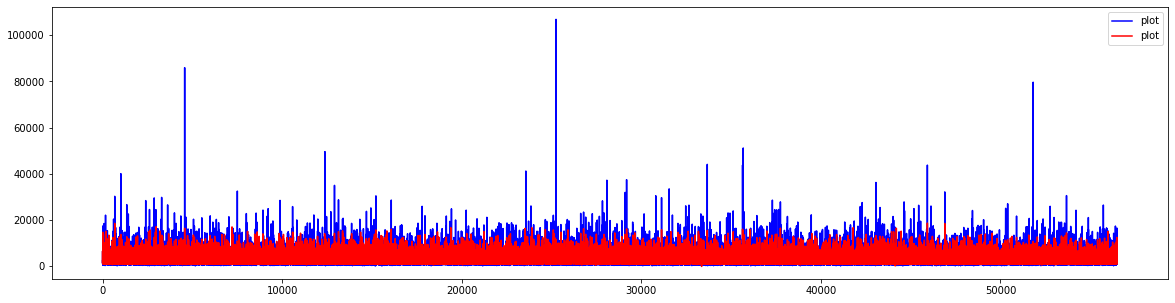

<Figure size 432x288 with 0 Axes>

In [ ]:
x = range(1, len(y_test)+1)
plt.figure(figsize=(20,5))
plt.plot(x, y_test, 'b', label='plot')
plt.plot(x, pred, 'r', label='plot')

plt.legend()
plt.show()
plt.clf()

In [ ]:
pred_corr=pred.flatten()
np.corrcoef(pred_corr, y_test.values)

array([[1.        , 0.73013841],
       [0.73013841, 1.        ]])